# Renaming Notebook for Drone images

Images are taken and renamed to the following format

DJIP4_TH_TKB_05_20181222T1743Z_0001.JPG

{dronetype}\_{country}\_{surveycode}\_{surveynumber}\_{localtime}\_{image_counter}.JPG


### 1. Run Exiftool on the input directory

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj 
import os
import shutil
import PIL
import xarray as xr
from functools import partial
pd.options.display.max_columns = None
pd.options.display.max_rows = None

/home/mor582/miniconda3/envs/pyAODN/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mor582/miniconda3/envs/pyAODN/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [34]:
inputdir = '~/seagrass/Thailand/Tang\ Khen\ Bay'
outputdir = '~/seagrass'
country = 'TH'
cameratype = 'RGB'
dronetype='DJIP4'
surveycode='TKB'
surveynumber=5
timedif = '+07'
destination =os.path.join(outputdir,country,surveycode,f'{surveynumber:03}')



In [35]:
!exiftool -r -ext JPG -a -json $inputdir > input.json

    1 directories scanned
  524 image files read


In [50]:

xifdata =pd.read_json('input.json')

In [53]:
xifdata['OriginalImageNumber'] =pd.to_numeric(xifdata.FileName.str.extract('.*_(?P<ImageNumber>\d*)')['ImageNumber'])

In [420]:
xifdata.index = pd.to_datetime(xifdata.DateTimeOriginal,format='%Y:%m:%d %H:%M:%S')
xifdata.DateTimeOriginal =pd.to_datetime(xifdata.DateTimeOriginal,format='%Y:%m:%d %H:%M:%S')
xifdata.sort_index(inplace=True)

DateTimeOriginal
2018-12-22 17:18:52   2018-12-22 17:18:52
2018-12-22 17:18:56   2018-12-22 17:18:56
2018-12-22 17:18:58   2018-12-22 17:18:58
2018-12-22 17:19:01   2018-12-22 17:19:01
2018-12-22 17:19:03   2018-12-22 17:19:03
2018-12-22 17:19:06   2018-12-22 17:19:06
2018-12-22 17:19:08   2018-12-22 17:19:08
2018-12-22 17:19:11   2018-12-22 17:19:11
2018-12-22 17:19:16   2018-12-22 17:19:16
2018-12-22 17:19:21   2018-12-22 17:19:21
2018-12-22 17:19:26   2018-12-22 17:19:26
2018-12-22 17:19:28   2018-12-22 17:19:28
2018-12-22 17:19:31   2018-12-22 17:19:31
2018-12-22 17:19:33   2018-12-22 17:19:33
2018-12-22 17:19:36   2018-12-22 17:19:36
2018-12-22 17:19:38   2018-12-22 17:19:38
2018-12-22 17:19:41   2018-12-22 17:19:41
2018-12-22 17:19:43   2018-12-22 17:19:43
2018-12-22 17:19:46   2018-12-22 17:19:46
2018-12-22 17:19:48   2018-12-22 17:19:48
2018-12-22 17:19:51   2018-12-22 17:19:51
2018-12-22 17:19:53   2018-12-22 17:19:53
2018-12-22 17:19:56   2018-12-22 17:19:56
2018-12-22 17:20:

In [55]:
def get_longitude(item):
    longitude =float(item[0]) + float(item[2][0:-1])/60 + float(item[3][0:-1])/3600
    return (longitude)
xifdata['Hem']=np.nan
xifdata.loc[xifdata['GPSLatitudeRef']=='North','Hem']=1
xifdata.loc[xifdata['GPSLatitudeRef']=='South','Hem']=-1
# Drop all pictures with No GPS
xifdata = xifdata[(~xifdata['GPSLongitude'].isna() | ~xifdata['GPSLatitude'].isna())]
xifdata['Longitude'] = np.nan
xifdata['Latitude'] = np.nan
xifdata['longitude']=xifdata['GPSLongitude'].str.split(' ',expand=True).apply(get_longitude,axis=1)
xifdata['latitude']=xifdata['GPSLatitude'].str.split(' ',expand=True).apply(get_longitude,axis=1) * xifdata['Hem']

myProj = Proj("+proj=utm +zone=47N, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
xifdata['Easting'], xifdata['Northing'] = myProj(xifdata['longitude'].values, xifdata['latitude'].values)



In [56]:
xifdata['LocalTime'] =  xifdata.index
xifdata['LocalTime'] = xifdata['LocalTime'].dt.strftime('%Y%m%dT%H%M%S')+timedif
xifdata['Counter'] = 1
xifdata['Counter'] = xifdata['Counter'].cumsum()
xifdata['NewName']=xifdata.apply(lambda item: f'{dronetype}_{country}_{surveycode}_{surveynumber:03}_{item.LocalTime}_{item.Counter:04}.JPG', axis=1)


In [348]:
pd.to_datetime(xifdata.iloc[40:100].LocalTime).diff()

DateTimeOriginal
2018-12-22 17:20:40        NaT
2018-12-22 17:20:44   00:00:04
2018-12-22 17:20:54   00:00:10
2018-12-22 17:20:56   00:00:02
2018-12-22 17:20:58   00:00:02
2018-12-22 17:21:01   00:00:03
2018-12-22 17:21:03   00:00:02
2018-12-22 17:21:06   00:00:03
2018-12-22 17:21:08   00:00:02
2018-12-22 17:21:11   00:00:03
2018-12-22 17:21:13   00:00:02
2018-12-22 17:21:16   00:00:03
2018-12-22 17:21:18   00:00:02
2018-12-22 17:21:21   00:00:03
2018-12-22 17:21:23   00:00:02
2018-12-22 17:21:26   00:00:03
2018-12-22 17:21:28   00:00:02
2018-12-22 17:21:31   00:00:03
2018-12-22 17:21:33   00:00:02
2018-12-22 17:21:36   00:00:03
2018-12-22 17:21:38   00:00:02
2018-12-22 17:21:41   00:00:03
2018-12-22 17:21:43   00:00:02
2018-12-22 17:21:46   00:00:03
2018-12-22 17:21:48   00:00:02
2018-12-22 17:21:51   00:00:03
2018-12-22 17:21:53   00:00:02
2018-12-22 17:21:56   00:00:03
2018-12-22 17:21:58   00:00:02
2018-12-22 17:22:01   00:00:03
2018-12-22 17:22:03   00:00:02
2018-12-22 17:22:06   

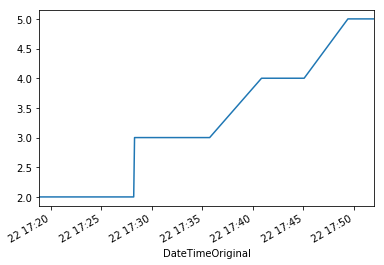

In [57]:
(xifdata['OriginalImageNumber'] - xifdata['Counter']).plot()

In [83]:
xifdata['OriginalImageNumber'].isin([136,137])

DateTimeOriginal
2018-12-22 17:18:52    False
2018-12-22 17:18:56    False
2018-12-22 17:18:58    False
2018-12-22 17:19:01    False
2018-12-22 17:19:03    False
2018-12-22 17:19:06    False
2018-12-22 17:19:08    False
2018-12-22 17:19:11    False
2018-12-22 17:19:16    False
2018-12-22 17:19:21    False
2018-12-22 17:19:26    False
2018-12-22 17:19:28    False
2018-12-22 17:19:31    False
2018-12-22 17:19:33    False
2018-12-22 17:19:36    False
2018-12-22 17:19:38    False
2018-12-22 17:19:41    False
2018-12-22 17:19:43    False
2018-12-22 17:19:46    False
2018-12-22 17:19:48    False
2018-12-22 17:19:51    False
2018-12-22 17:19:53    False
2018-12-22 17:19:56    False
2018-12-22 17:20:00    False
2018-12-22 17:20:01    False
2018-12-22 17:20:05    False
2018-12-22 17:20:06    False
2018-12-22 17:20:10    False
2018-12-22 17:20:11    False
2018-12-22 17:20:15    False
2018-12-22 17:20:16    False
2018-12-22 17:20:18    False
2018-12-22 17:20:21    False
2018-12-22 17:20:23    Fal

In [58]:
xifdata = xifdata[['AbsoluteAltitude','CamReverse','CameraPitch','CameraRoll','CameraYaw',
 'CircleOfConfusion','DateTimeOriginal','ExifImageHeight','ExifImageWidth',
 'ExposureTime','FNumber','FOV','FileSource','FlightPitchDegree','FlightRollDegree',
 'FlightYawDegree','FocalLength','FocalLength35efl','FocalLengthIn35mmFormat',
 'GPSAltitude','GPSAltitudeRef','GPSLatitude','GPSLatitudeRef','GPSLongitude',
 'GPSLongitudeRef','GPSPosition','GPSVersionID','GainControl',
 'GimbalPitchDegree','GimbalReverse','GimbalRollDegree','GimbalYawDegree',
 'ISO','ImageHeight','ImageWidth','Orientation','Pitch','RelativeAltitude',
 'ResolutionUnit','Roll','Saturation','ScaleFactor35efl','SerialNumber',
 'Sharpness','ShutterSpeed','ShutterSpeedValue','Software',
 'SourceFile','SpeedX','SpeedY','SpeedZ','SubjectDistance',
 'SubjectDistanceRange','Version','WhiteBalance','Yaw', 'Hem', 'Longitude', 'Latitude',
 'Easting', 'Northing', 'LocalTime', 'Counter', 'NewName','FileName','OriginalImageNumber']]


In [59]:
os.path.join(outputdir,country,surveycode,f'{surveynumber:03}')

'~/seagrass/TH/TKB/005'

In [60]:
os.makedirs(os.path.join(outputdir,country,surveycode,f'{surveynumber:03}'),exist_ok=True)

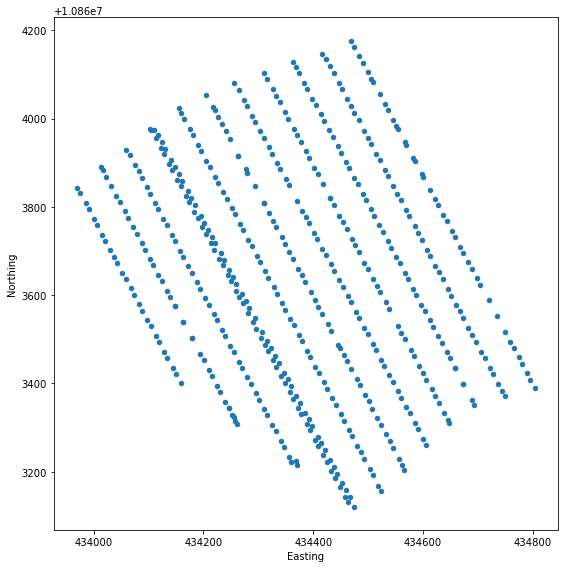

In [61]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,8))
xifdata.plot.scatter(ax=ax,x='Easting',y='Northing')
plt.tight_layout()

In [276]:
from shapely.geometry import Polygon
def to_real_wrold(index,altitude,focallen):
    return (index/focallen)*altitude


def from_real_world(item,easting,northing):
    easting =easting - item.Easting
    northing = northing - item.Northing
    rads = np.deg2rad(item.FlightYawDegree)
    A = np.array([[np.cos(rads),np.sin(rads)],[-np.sin(rads),np.cos(rads)]])
    B = np.array([easting,northing])
    C = np.linalg.solve(A,B)
    C = 3666.666504*C/item.RelativeAltitude
    return {'x':int(np.round(C[0]+float(item.ImageWidth)/2)),'y':int(np.round(C[1] -float(item.ImageHeight)/2)*-1)}

    

def calculateposition(item,x,y):
    x = x-float(item.ImageWidth)/2
    y= (y -float(item.ImageHeight)/2)*-1
    x = to_real_wrold(x,item.RelativeAltitude,3666.666504)
    y = to_real_wrold(y,item.RelativeAltitude,3666.666504)
    rads = np.deg2rad(item.FlightYawDegree)
    xx = (x * np.cos(rads) +  y * np.sin(rads))+ item.Easting 
    yy = (-x * np.sin(rads)  +  y  * np.cos(rads))+ item.Northing
    return (xx,yy)

def imagecorners(item):
    xw =float(item.ImageWidth)/2
    yw=float(item.ImageHeight)/2
    x = to_real_wrold(np.array([xw,xw,-xw,-xw]),item.RelativeAltitude,3666.666504)
    y = to_real_wrold(np.array([yw,-yw,-yw,yw]),item.RelativeAltitude,3666.666504)
    rads = np.deg2rad(item.FlightYawDegree)
    xx = (x * np.cos(rads) +  y * np.sin(rads))+ item.Easting 
    yy = (-x * np.sin(rads)  +  y  * np.cos(rads))+ item.Northing
    return xx,yy

def make_image_poly(item):
    xx,yy =imagecorners(item)
    return Polygon(zip(xx,yy))




In [63]:
xifdata['Polygon'] = xifdata.apply(make_image_poly,axis=1)

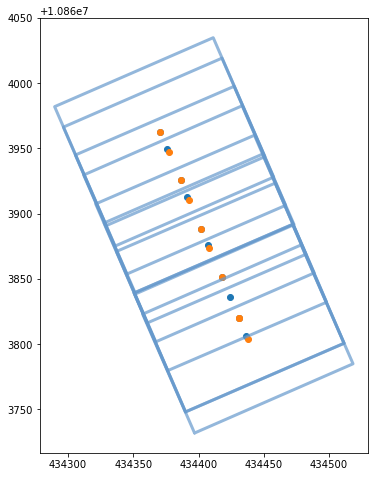

In [450]:
fig, ax = plt.subplots(figsize=(8,8))

for index,row in xifdata[140:150].iterrows():
    (x,y)=row.Polygon.exterior.xy
    ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)
ax.set_aspect(1)

plt.scatter(e,n)
plt.scatter(xifdata[140:150].Easting,xifdata[140:150].Northing)

In [423]:
leg.DateTimeOriginal[0]

Timestamp('2018-12-22 17:25:12')

In [430]:
leg.DateTimeOriginal[0:2]

DateTimeOriginal
2018-12-22 17:25:12   2018-12-22 17:25:12
2018-12-22 17:25:15   2018-12-22 17:25:15
Name: DateTimeOriginal, dtype: datetime64[ns]

In [439]:
np.datetime64(leg.DateTimeOriginal[0]).astype("int64")

1545499512000000

In [445]:
leg = xifdata[140:150]
s=(np.datetime64(leg.DateTimeOriginal[0])+(pd.to_timedelta('2.5S')*np.arange(0,10,1))).astype("float")
leg.DateTimeOriginal.astype('int64').astype('float')

DateTimeOriginal
2018-12-22 17:25:12    1.545500e+18
2018-12-22 17:25:15    1.545500e+18
2018-12-22 17:25:17    1.545500e+18
2018-12-22 17:25:20    1.545500e+18
2018-12-22 17:25:22    1.545500e+18
2018-12-22 17:25:25    1.545500e+18
2018-12-22 17:25:27    1.545500e+18
2018-12-22 17:25:32    1.545500e+18
2018-12-22 17:25:32    1.545500e+18
2018-12-22 17:25:35    1.545500e+18
Name: DateTimeOriginal, dtype: float64

In [448]:

n =np.interp(s,leg.DateTimeOriginal.astype('int64').astype('float'),leg.Northing)
e = np.interp(s,leg.DateTimeOriginal.astype('int64').astype('float'),leg.Easting)

In [447]:
 np.power(np.power(xifdata[140:150].Easting.diff(),2) + np.power(xifdata[140:150].Northing.diff(),2),0.5)/7

DateTimeOriginal
2018-12-22 17:25:12         NaN
2018-12-22 17:25:15    2.435707
2018-12-22 17:25:17    3.339746
2018-12-22 17:25:20    2.337822
2018-12-22 17:25:22    3.461157
2018-12-22 17:25:25    2.257403
2018-12-22 17:25:27    3.437629
2018-12-22 17:25:32    4.911746
2018-12-22 17:25:32    0.000000
2018-12-22 17:25:35    2.476069
dtype: float64

In [376]:
xifdata[140:150].OriginalImageNumber

DateTimeOriginal
2018-12-22 17:25:12    143
2018-12-22 17:25:15    144
2018-12-22 17:25:17    145
2018-12-22 17:25:20    146
2018-12-22 17:25:22    147
2018-12-22 17:25:25    148
2018-12-22 17:25:27    149
2018-12-22 17:25:32    150
2018-12-22 17:25:32    151
2018-12-22 17:25:35    152
Name: OriginalImageNumber, dtype: int64

In [287]:
def cut_tile(item,pix,x,y,pixeldim):
    ds = xr.Dataset()
    ds['image'] = xr.DataArray(pix[y:(y+squaresize),x:(x+squaresize),:],
                              dims=['dy','dx','rgb'],coords={'dy':pixeldim,'dx':pixeldim,'rgb':['r','g','b']})
    cx,cy=calculateposition(item,x+squaresize/2,y+squaresize/2)
    ds.coords['easting'] = cx
    ds.coords['northing'] =cy 
    ds.coords['imagenumber'] = item.OriginalImageNumber
    return  ds

In [389]:
squaresize =256
item = xifdata.loc[pd.to_datetime('2018-12-22 17:25:25')]
img = Image.open(item.SourceFile)
pix = np.array(img)
tile1 = cut_tile(item,pix,2000,2000,pixeldim)
item2 = xifdata.loc[pd.to_datetime('2018-12-22 17:25:27')]
result =from_real_world(item2,tile1.easting,tile1.northing)
img = Image.open(item2.SourceFile)
pix = np.array(img)
tile2 = cut_tile(item2,pix,result['x']-128,result['y']-50,pixeldim)

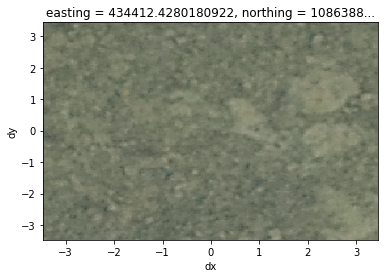

In [390]:
tile1.image.plot.imshow(rgb='rgb')

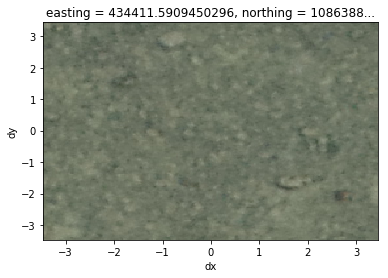

In [391]:
tile2.image.plot.imshow(rgb='rgb')

In [66]:
item = xifdata.iloc[0]
xc,yc =imagecorners(item)
pixsize=np.power(np.power(xc[1] -xc[2],2)+np.power(yc[1] -yc[2],2),0.5)/item.ImageWidth
pixsize

0.02700000119777741

In [69]:
pixeldim=np.arange(-128,128)*pixsize

In [70]:
squaresize = 256
yi =np.arange(0,item.ImageHeight,squaresize)
xi =np.arange(0,item.ImageWidth,squaresize)
yi[-1] = item.ImageHeight-squaresize


In [217]:
from PIL import Image

def process_tiles(item,squaresize,pixeldim):
    img = Image.open(item.SourceFile)
    pix = np.array(img)
    tiles =[]
    for x  in xi:
        for y in yi:
            ds = xr.Dataset()
            ds['image'] = xr.DataArray(pix[y:(y+squaresize),x:(x+squaresize),:],
                                      dims=['dy','dx','rgb'],coords={'dy':pixeldim,'dx':pixeldim,'rgb':['r','g','b']})
            cx,cy=calculateposition(item,x+squaresize/2,y+squaresize/2)
            ds.coords['easting'] = cx
            ds.coords['northing'] =cy 
            ds.coords['imagenumber'] = item.OriginalImageNumber
            tiles.append(ds)
    return  xr.concat(tiles,dim='tile')
        
proctile = partial(process_tiles, squaresize=squaresize,pixeldim=pixeldim)

In [ ]:
image1 = xif

In [218]:
result =xifdata[7:9].apply(proctile,axis=1)

In [225]:
result.values

array([<xarray.Dataset>
Dimensions:      (dx: 256, dy: 256, rgb: 3, tile: 285)
Coordinates:
  * dy           (dy) float64 -3.456 -3.429 -3.402 -3.375 ... 3.375 3.402 3.429
  * dx           (dx) float64 -3.456 -3.429 -3.402 -3.375 ... 3.375 3.402 3.429
  * rgb          (rgb) <U1 'r' 'g' 'b'
    imagenumber  int64 10
    easting      (tile) float64 4.347e+05 4.347e+05 ... 4.348e+05 4.348e+05
    northing     (tile) float64 1.086e+07 1.086e+07 ... 1.086e+07 1.086e+07
Dimensions without coordinates: tile
Data variables:
    image        (tile, dy, dx, rgb) uint8 125 160 156 128 ... 161 57 161 160,
       <xarray.Dataset>
Dimensions:      (dx: 256, dy: 256, rgb: 3, tile: 285)
Coordinates:
  * dy           (dy) float64 -3.456 -3.429 -3.402 -3.375 ... 3.375 3.402 3.429
  * dx           (dx) float64 -3.456 -3.429 -3.402 -3.375 ... 3.375 3.402 3.429
  * rgb          (rgb) <U1 'r' 'g' 'b'
    imagenumber  int64 11
    easting      (tile) float64 4.347e+05 4.347e+05 ... 4.348e+05 4.348e+05
    no

In [204]:
xifdata['OriginalImageNumber'].isin([136,137])

DateTimeOriginal
2018-12-22 17:18:52    False
2018-12-22 17:18:56    False
2018-12-22 17:18:58    False
2018-12-22 17:19:01    False
2018-12-22 17:19:03    False
2018-12-22 17:19:06    False
2018-12-22 17:19:08    False
2018-12-22 17:19:11    False
2018-12-22 17:19:16    False
2018-12-22 17:19:21    False
2018-12-22 17:19:26    False
2018-12-22 17:19:28    False
2018-12-22 17:19:31    False
2018-12-22 17:19:33    False
2018-12-22 17:19:36    False
2018-12-22 17:19:38    False
2018-12-22 17:19:41    False
2018-12-22 17:19:43    False
2018-12-22 17:19:46    False
2018-12-22 17:19:48    False
2018-12-22 17:19:51    False
2018-12-22 17:19:53    False
2018-12-22 17:19:56    False
2018-12-22 17:20:00    False
2018-12-22 17:20:01    False
2018-12-22 17:20:05    False
2018-12-22 17:20:06    False
2018-12-22 17:20:10    False
2018-12-22 17:20:11    False
2018-12-22 17:20:15    False
2018-12-22 17:20:16    False
2018-12-22 17:20:18    False
2018-12-22 17:20:21    False
2018-12-22 17:20:23    Fal

In [222]:
output

['image', 'image']

In [226]:
from itertools import chain
output =list(chain.from_iterable(result))

tiles =xr.concat(result.values,dim='imagenumber')

In [227]:
tiles

<xarray.Dataset>
Dimensions:      (dx: 256, dy: 256, imagenumber: 2, rgb: 3, tile: 285)
Coordinates:
  * dy           (dy) float64 -3.456 -3.429 -3.402 -3.375 ... 3.375 3.402 3.429
  * dx           (dx) float64 -3.456 -3.429 -3.402 -3.375 ... 3.375 3.402 3.429
  * rgb          (rgb) <U1 'r' 'g' 'b'
  * imagenumber  (imagenumber) int64 10 11
    easting      (imagenumber, tile) float64 4.347e+05 4.347e+05 ... 4.348e+05
    northing     (imagenumber, tile) float64 1.086e+07 1.086e+07 ... 1.086e+07
Dimensions without coordinates: tile
Data variables:
    image        (imagenumber, tile, dy, dx, rgb) uint8 125 160 156 ... 153 153

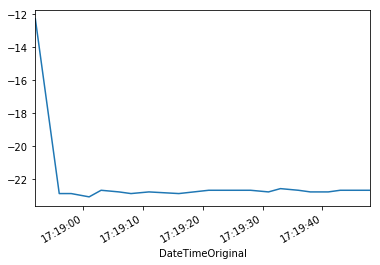

In [184]:
xifdata[0:20].FlightYawDegree.plot()

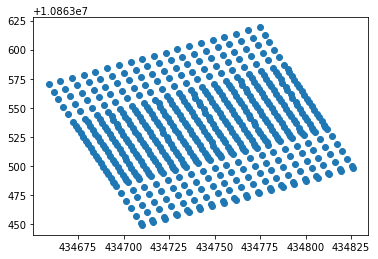

In [206]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.scatter(tiles.easting,tiles.northing)


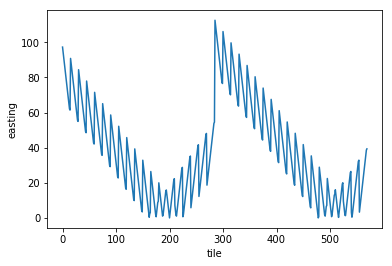

In [207]:
find =tiles.isel(tile=200)[['northing','easting']]
abs(tiles.easting-tiles.easting[200]).plot()

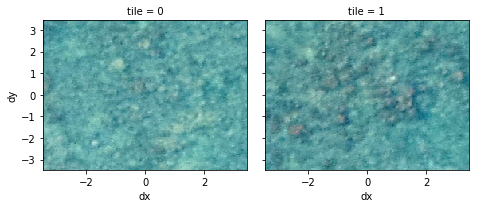

In [208]:
tiles.isel(tile=slice(190,192)).image.plot.imshow(col='tile',col_wrap=5,rgb='rgb')

In [230]:
tiles.easting

<xarray.DataArray 'easting' (imagenumber: 2, tile: 285)>
array([[434674.111631, 434676.8199  , 434679.528169, ..., 434822.579774,
        434825.288043, 434825.96511 ],
       [434658.816641, 434661.53615 , 434664.25566 , ..., 434807.334411,
        434810.053921, 434810.733798]])
Coordinates:
  * imagenumber  (imagenumber) int64 10 11
    easting      (imagenumber, tile) float64 4.347e+05 4.347e+05 ... 4.348e+05
    northing     (imagenumber, tile) float64 1.086e+07 1.086e+07 ... 1.086e+07
Dimensions without coordinates: tile

In [228]:
tiles.image[(abs(tiles.easting-tiles.easting[50])<4) & (abs(tiles.northing-tiles.northing[50])<4)].plot.imshow(col='tile',col_wrap=5,rgb='rgb')

IndexError: index 50 is out of bounds for axis 0 with size 2

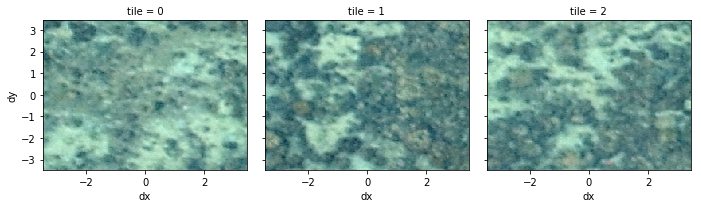

In [214]:
tiles.image[[49,50,51]].plot.imshow(col='tile',col_wrap=5,rgb='rgb')

In [121]:
calculateposition(item,0,0)

(434750.7104042753, 10863327.744430125)

In [146]:
str(item.Polygon)

'POLYGON ((434858.0412093098 10863451.9563711, 434879.0238511672 10863355.72128593, 434750.7104042753 10863327.74443012, 434729.7277624179 10863423.97951529, 434858.0412093098 10863451.9563711))'